EQUIPO 4:  

Natalia Sofía Salgado García        A01571008  
Luis Fernando Manzanares Sánchez    A01283738  
Emiliano Salinas Del Bosque         A01570972  
Alejandro Guevara Olivares          A00834438  

## Reto: Cruce Peatonal Inteligente

In [3]:
import agentpy as ap
import numpy as np
import random
import matplotlib.pyplot as plt
import IPython.display

# Define the Message class
class Message:
    def __init__(self, sender, performative, content=None):
        self.sender = sender
        self.performative = performative
        self.content = content

# Define the TrafficLight agent class
class TrafficLight(ap.Agent):
    def setup(self):
        self.state = 1  # 0: Red, 1: Green, 2: Yellow
        self.pedestrian_request = False
        self.pedestrian_request_timer = 0
        self.red_timer = 0
        self.red_duration = self.model.p.red_duration
        self.request_delay = self.model.p.request_delay
        self.timer = 0

    def update_color_smart(self):
        if self.pedestrian_request:
            self.pedestrian_request_timer += 1
            if self.pedestrian_request_timer >= self.request_delay:
                self.state = 2  # Turn yellow
                if self.pedestrian_request_timer >= self.request_delay * 3/2:
                    self.state = 0  # Turn red
                    self.model.cars_crossed_per_light.append(self.model.cars_counter) # Record the number of cars crossed during the green light
                    self.model.cars_counter = 0
                    self.red_timer = self.red_duration
                    self.pedestrian_request = False  # Reset the request
                    self.pedestrian_request_timer = 0
        elif self.red_timer > 0:
            self.model.total_red_light += 1  # Count the total time the light is red
            self.red_timer -= 1
            if self.red_timer == 0:  # Red timer ran out
                if not any(isinstance(agent, Pedestrian) for agent in self.model.place.agents):  # No pedestrians waiting
                    self.state = 1  # Change to green
        else:
            self.state = 1  # Default to green

    def update_color_normal(self):
        if self.state == 1:  # Green
            if self.timer >= self.model.p.request_delay:
                self.state = 2  # Switch to yellow
                self.timer = 0
        elif self.state == 2:  # Yellow
            if self.timer >= self.model.p.request_delay/2:
                self.state = 0  # Switch to red
                self.model.cars_crossed_per_light.append(self.model.cars_counter) # Record the number of cars crossed during the green light
                self.model.cars_counter = 0
                self.timer = 0
                self.red_timer = self.model.p.red_duration
        elif self.state == 0:  # Red
            self.red_timer -= 1
            self.model.total_red_light += 1 # Count the total time the light is red
            if self.timer >= self.model.p.red_duration:
                self.state = 1  # Switch to green
                self.timer = 0
                
        self.timer += 1
    
    def handle_message(self, message):
        if message.performative == "REQUEST":
            if not self.pedestrian_request and self.red_timer == 0:
                self.pedestrian_request = True
                self.pedestrian_request_timer = 0

# Define the Pedestrian agent class
class Pedestrian(ap.Agent):
    def setup(self):
        self.state = 4
        
    def move(self):
        traffic_light = self.model.traffic_light.state[0]
        
        pos = self.model.place.positions[self]
        new_pos = (pos[0], pos[1] - 1)
        
        if pos[1] == self.model.p.width - 1:
            self.model.place.move_by(self, (0, -1))
            
        # Send a request to the traffic light if near the crossing if smart crossing is enabled
        if self.model.p.smart_crossing:
            # Request red light if near the crossing and the light is green
            if pos[1] == self.model.p.width - 2 and traffic_light == 1:
                message = Message(self, "REQUEST")
                self.model.traffic_light[0].handle_message(message)
        
        if traffic_light == 0 and new_pos not in self.model.place.positions.values():
            # Calculate the time needed for the pedestrian to cross
            cells_to_cross = pos[1]  # Number of cells to cross to reach the leftmost column
            time_to_cross = cells_to_cross  # Each step moves the pedestrian one cell
            
            if self.model.traffic_light[0].red_timer < time_to_cross:
                return  # Wait for the next step
            
            self.model.place.move_by(self, (0, -1))


# Define the Vehicle agent class
class Vehicle(ap.Agent):
    def setup(self):
        self.state = 3
        self.reached_top = False
        self.time_on_top = 0
        self.just_added = True  # Flag to indicate if the vehicle was just added

    def move(self):
        if self.just_added:
            self.just_added = False  # Skip movement if just added
            return

        traffic_light = self.model.traffic_light.state[0]
        
        pos = self.model.place.positions[self]
        new_pos = (pos[0] - 1, pos[1])
        
        if traffic_light == 0:
            if new_pos[0] > 1 and new_pos not in self.model.place.positions.values():
                self.model.place.move_by(self, (-1, 0))
        else:
            if new_pos not in self.model.place.positions.values():
                self.model.place.move_by(self, (-1, 0))
        
        # Check if the vehicle has reached the top row
        if new_pos[0] == 0:
            if not self.reached_top:
                self.reached_top = True
                self.time_on_top = self.model.t

# Define the CrossingModel model class
class CrossingModel(ap.Model):
    def setup(self):
        self.track_empty = True
        self.place = ap.Grid(self, (self.p.height, self.p.width), track_empty=True)
        self.traffic_light = ap.AgentList(self, 1, TrafficLight)  # Create a list with one TrafficLight agent
        self.place.add_agents(self.traffic_light, positions=[(1, self.p.width - 2)], empty=True)
        self.cars_crossed = 0
        self.cars_counter = 0
        self.cars_crossed_per_light = []
        self.pedestrians_crossed = 0
        self.total_red_light = 0     
        
    def step(self):
        # Update the traffic light color
        if self.p.smart_crossing: # Use smart crossing
            self.traffic_light.update_color_smart()
        else:
            self.traffic_light.update_color_normal()
        
        self.add_vehicle()
        self.add_pedestrian()
        
        # Move existing vehicles and pedestrians
        agents_to_remove = []
        for agent in self.place.agents:
            if isinstance(agent, Vehicle):
                agent.move()
                pos = self.place.positions[agent]
                # Remove the vehicle only if it has reached the top row and stayed there for one time step
                if agent.reached_top and (self.t - agent.time_on_top) >= 1:
                    self.cars_crossed += 1
                    self.cars_counter += 1
                    agents_to_remove.append(agent)
            elif isinstance(agent, Pedestrian):
                agent.move()
                pos = self.place.positions[agent]
                # Remove the pedestrian if they reach the leftmost column
                if pos[1] == 0:
                    self.pedestrians_crossed += 1
                    agents_to_remove.append(agent)
        
        # Remove agents outside of the iteration
        for agent in agents_to_remove:
            self.place.remove_agents(agent)
        
    def add_vehicle(self):
        # Find all columns in the bottom row
        bottom_row = self.p.height - 1
        all_columns = list(range(2, self.p.width - 2))
        
        # Get the positions of all vehicles
        vehicle_positions = [pos for agent, pos in self.place.positions.items() if isinstance(agent, Vehicle)]
        occupied_columns = [pos[1] for pos in vehicle_positions if pos[0] == bottom_row]
        available_columns = [col for col in all_columns if col not in occupied_columns]
        
        # If there are no available columns, do not add a vehicle
        if not available_columns:
            return
        
        column = random.choice(available_columns)
        vehicle = Vehicle(self)
        self.place.add_agents([vehicle], positions=[(bottom_row, column)], empty=True)
        # print(f"Added vehicle at position: {(bottom_row, column)}")

    def add_pedestrian(self):
        if random.random() < self.p.pedestrian_probability:
            if not any(isinstance(agent, Pedestrian) for agent in self.place.agents):
                pedestrian = Pedestrian(self)
                self.place.add_agents([pedestrian], positions=[(0, self.p.width - 1)], empty=True)
                # print("Pedestrian added at time-step", self.t)

def animation_plot(model, ax):
    attr_grid = model.place.attr_grid('state')
    sidewalk = np.zeros(model.place.shape, dtype=int)
    street = np.zeros(model.place.shape, dtype=int)
    color_dict = {0: '#FF0000', 1: '#00FF00', 2: '#FFFF00', 3: '#FF00FF', 4: '#00FFFF', None: 'none'}
    
    # Custom coloring of non-agent cells
    for i in range(model.p.height):
        for j in range(model.p.width):
            if j <= 1 or j >= model.p.width - 2:  # Sidewalk on left and right sides     
                sidewalk[i][j] = 1  # Mark sidewalk cells as 1
            else:
                street[i][j] = 1
    
    ax.imshow(street, cmap='Greys', alpha=1)
    ax.imshow(sidewalk, cmap='Greys', alpha=0.3)
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Crossing model \n Time-step: {model.t}")
    
def metrics(model):
    if model.cars_crossed_per_light == []:
            model.cars_crossed_per_light.append(model.cars_crossed)
    return {
        'Total red light time': model.total_red_light,
        'Total cars crossed': model.cars_crossed,
        'Total pedestrians crossed': model.pedestrians_crossed,
        'Cars crossed per green light': model.cars_crossed_per_light
    }

# Model parameters
parameters = {
    'steps': 200,
    'height': 12,
    'width': 9,
    'pedestrian_probability': 0.01,
    'request_delay': 30,
    'red_duration': 15,
    'smart_crossing': True,
}

# Create the model
model = CrossingModel(parameters)
# model.run(display=False)
# metrics(model)

# Set up the animation
fig, ax = plt.subplots()
animation = ap.animate(model, fig, ax, animation_plot)

# Display the animation
IPython.display.HTML(animation.to_jshtml())  

### Análisis

#### Total de carros que cruzan con cantidad de carriles variable

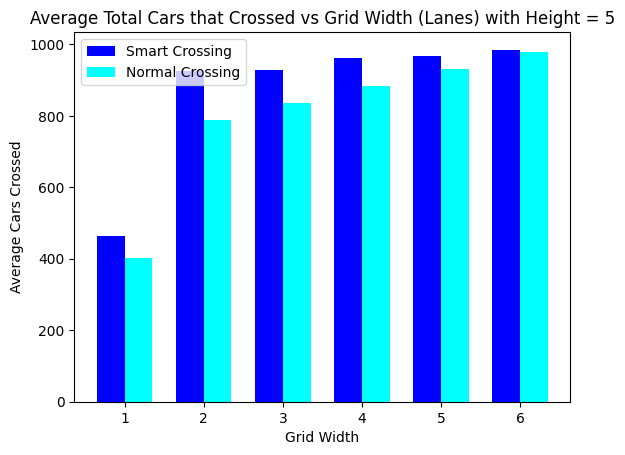

In [5]:
# Define the function to run the simulations
def run_varying_lanes(n, widths, height):
    smart_crossing_avg_cars = []
    normal_crossing_avg_cars = []
    
    for width in widths:
        smart_cars_crossed = []
        normal_cars_crossed = []
        
        for i in range(n):
            # Run smart crossing simulation
            smart_params = {
                'steps': 1000,
                'height': height,
                'width': width,
                'pedestrian_probability': 0.01,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': True,
            }
            smart_model = CrossingModel(smart_params)
            smart_model.run(display=False)
            smart_metrics = metrics(smart_model)
            smart_cars_crossed.append(smart_metrics['Total cars crossed'])

            # Run normal crossing simulation
            normal_params = {
                'steps': 1000,
                'height': height,
                'width': width,
                'pedestrian_probability': 0.01,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': False,
            }
            normal_model = CrossingModel(normal_params)
            normal_model.run(display=False)
            normal_metrics = metrics(normal_model)
            normal_cars_crossed.append(normal_metrics['Total cars crossed'])
        
        # Calculate average cars crossed for both smart and normal crossing
        smart_crossing_avg_cars.append(np.mean(smart_cars_crossed))
        normal_crossing_avg_cars.append(np.mean(normal_cars_crossed))
    
    # Plot the results
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = np.arange(len(widths))
    
    bar1 = ax.bar(index, smart_crossing_avg_cars, bar_width, label='Smart Crossing', color='blue')
    bar2 = ax.bar(index + bar_width, normal_crossing_avg_cars, bar_width, label='Normal Crossing', color='cyan')
    
    ax.set_xlabel('Grid Width')
    ax.set_ylabel('Average Cars Crossed')
    ax.set_title('Average Total Cars that Crossed vs Grid Width (Lanes) with Height = 5')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([str(width-4) for width in widths])
    ax.legend()
    
    plt.show()

n = 10  # Number of simulations for each type
widths = [5,6,7,8,9,10]
height = 5  # Keeping height constant
run_varying_lanes(n, widths, height)

#### Tiempo total promedio de luz en rojo

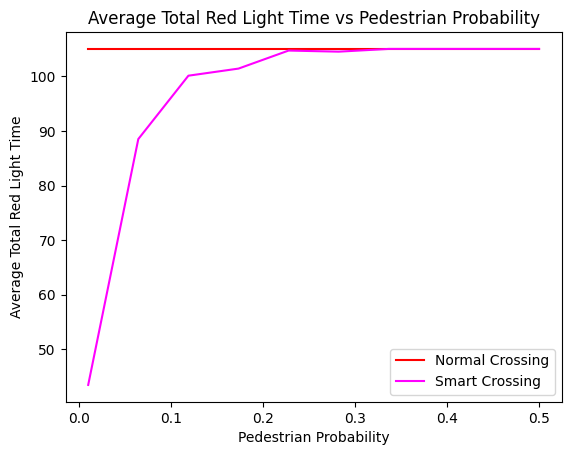

In [9]:
# Define the function to run the simulations
def run_red_light_simulations(n, pedestrian_probabilities, steps):
    smart_crossing_avg_red_light = []
    normal_crossing_avg_red_light = []
    
    for p in pedestrian_probabilities:
        smart_red_light_times = []
        normal_red_light_times = []
        
        for i in range(n):
            # Run smart crossing simulation
            smart_params = {
                'steps': steps,
                'height': 12,
                'width': 9,
                'pedestrian_probability': p,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': True,
            }
            smart_model = CrossingModel(smart_params)
            smart_model.run(display=False)
            smart_metrics = metrics(smart_model)
            smart_red_light_times.append(smart_metrics['Total red light time'])

            # Run normal crossing simulation
            normal_params = {
                'steps': steps,
                'height': 12,
                'width': 9,
                'pedestrian_probability': p,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': False,
            }
            normal_model = CrossingModel(normal_params)
            normal_model.run(display=False)
            normal_metrics = metrics(normal_model)
            normal_red_light_times.append(normal_metrics['Total red light time'])
        
        # Calculate average total red light time for both smart and normal crossing
        smart_crossing_avg_red_light.append(np.mean(smart_red_light_times))
        normal_crossing_avg_red_light.append(np.mean(normal_red_light_times))
    
    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(pedestrian_probabilities, normal_crossing_avg_red_light, label='Normal Crossing', color='red')
    ax.plot(pedestrian_probabilities, smart_crossing_avg_red_light, label='Smart Crossing', color='magenta')
    
    ax.set_xlabel('Pedestrian Probability')
    ax.set_ylabel('Average Total Red Light Time')
    ax.set_title('Average Total Red Light Time vs Pedestrian Probability')
    ax.legend()
    
    plt.show()

n = 10  # Number of simulations for each type
steps = 450
pedestrian_probabilities = np.linspace(0.01, 0.5, 10)
run_red_light_simulations(n, pedestrian_probabilities, steps)

#### Promedio de máxima cantidad de carros que cruzan en una luz verde

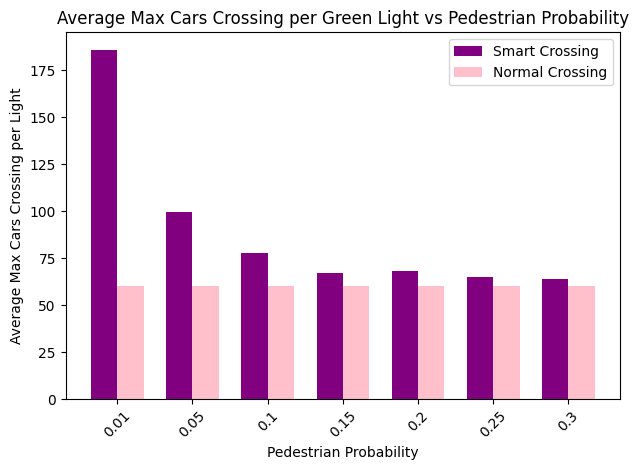

In [8]:
def run_max_cars(n, pedestrian_probabilities, steps):
    smart_crossing_avg_max_cars = []
    normal_crossing_avg_max_cars = []
    
    for p in pedestrian_probabilities:
        smart_max_cars = []
        normal_max_cars = []
        
        for i in range(n):
            # Run smart crossing simulation
            smart_params = {
                'steps': steps,
                'height': 12,
                'width': 9,
                'pedestrian_probability': p,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': True,
            }
            smart_model = CrossingModel(smart_params)
            smart_model.run(display=False)
            smart_metrics = metrics(smart_model)
            smart_max_cars.append(max(smart_metrics['Cars crossed per green light']))

            # Run normal crossing simulation
            normal_params = {
                'steps': steps,
                'height': 12,
                'width': 9,
                'pedestrian_probability': p,
                'request_delay': 30,
                'red_duration': 15,
                'smart_crossing': False,
            }
            normal_model = CrossingModel(normal_params)
            normal_model.run(display=False)
            normal_metrics = metrics(normal_model)
            normal_max_cars.append(max(normal_metrics['Cars crossed per green light']))
        
        # Calculate average maximum number of cars crossing per light for both smart and normal crossing
        smart_crossing_avg_max_cars.append(np.mean(smart_max_cars))
        normal_crossing_avg_max_cars.append(np.mean(normal_max_cars))
    
    # Plot the results
    fig, ax = plt.subplots()
    index = np.arange(len(pedestrian_probabilities))
    bar_width = 0.35
    
    rects1 = ax.bar(index, smart_crossing_avg_max_cars, bar_width, label='Smart Crossing', color='purple')
    rects2 = ax.bar(index + bar_width, normal_crossing_avg_max_cars, bar_width, label='Normal Crossing', color='pink')

    ax.set_xlabel('Pedestrian Probability')
    ax.set_ylabel('Average Max Cars Crossing per Light')
    ax.set_title('Average Max Cars Crossing per Green Light vs Pedestrian Probability')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(pedestrian_probabilities, rotation=45) 
    ax.set_xticklabels(pedestrian_probabilities)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage
n = 10  # Number of simulations for each type
steps = 450
pedestrian_probabilities = (0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)
run_max_cars(n, pedestrian_probabilities, steps)
